In [11]:
import pandas as pd
import json
import os
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
# from konlpy.tag import Okt
# from konlpy.tag import Mecab
import numpy as np

In [75]:
file_list = ['육아_이야기.json','요리_레시피.json','건강_운동.json','멘탈관리_심리탐구.json','문화_예술.json',
            '인문학_철학.json','쉽게_읽는_역사.json','우리집_반려동물.json','사랑_이별.json','감성_에세이.json',
            '지구한바퀴_세계여행.json','시사_이슈.json','IT_트렌드.json','취향저격_영화리뷰.json','오늘은_이런책.json',
            '뮤직_인사이드.json','직장인_현실조언.json','스타트업_경험담.json']

In [77]:
dir_name = 'C:/Users/KIHyuk/Desktop/brunch_data/json'

def get_file_list(dir_name): # file name들을 가져오는 함수 # 폴더명 인자 # 폴더가 위치한 경로를 인자로
    return os.listdir(dir_name) # 폴더 내 파일명을 리스트 형태로 반환 

# file_list = get_file_list(dir_name)

def pre_keyword(x):
    tmp = []
    for val in x:
        tmp.append(val.replace("\n","").replace(" ",""))
    return tmp

def pre_comment(x):
    if len(x) == 0:
        return None
    else :
        return x

def pre_text(x):
    return str(x)

def pre_datetime(x):
    x = x.split('T')[0]
    x = pd.to_datetime(x,format="%Y-%m-%d")
    return x

all_df = pd.DataFrame(columns=['class','text'])
each_df = {}
class_name = []

for file in file_list:
    with open('C:/Users/KIHyuk/Desktop/brunch_data/json/'+file,encoding='UTF8') as json_file:
        json_data = json.load(json_file)

    class_name.append(file[:-5])
    
    df = pd.DataFrame(json_data['data'],
                  columns=['title','keyword','text','nickname','publish_date','likes','share','comment','url','url_plink'])
    df = df.dropna(subset=['text'])
    df['keyword'] = df['keyword'].apply(pre_keyword)
    df['comment'] = df['comment'].apply(pre_comment)
    df['text'] = df['text'].apply(pre_text)
    df['publish_date'] = df['publish_date'].apply(pre_datetime)
    df.insert(0,"class",file[:-5])

    all_df = pd.concat([all_df,df[['class','title','text','keyword','likes','share','comment','publish_date','url']]])
    each_df[file[:-5]] = df


to_categorical = [i for i in range(18)]
class_condition = {}
for a,b in zip(class_name,to_categorical):
    class_condition[a] = b

all_df['ori_class'] = all_df['class']
all_df['class'] = all_df['class'].map(class_condition)
all_df = all_df.reset_index(drop=True)

import re
def pre_text_2(x):
    pa = re.compile("^\\\\xa0|xa")
    pa1 = re.compile(r"'http.*?'") # 전체 url 제거
    pa2 = re.compile(r'\([^)]*\)') # () 사이 문자 
    pa3 = re.compile('[^\w\s]') # 특수문자 삭제
    pa4 = re.compile(r'[^a-zA-Zㄱ-힗]')

    x = re.sub(pa,' ',x)
    x = re.sub(pa1,' ',x)
    x = re.sub(pa2,' ',x)
    x = re.sub(pa3, ' ',x)
    x = re.sub(pa4, ' ',x)
    x = x.strip()
    x = " ".join(x.split())
    return x 

all_df['text'] = all_df['text'].apply(pre_text_2)

In [78]:
del_list = []
for idx,text in enumerate(all_df['text']):
    if len(text) < 500:
        del_list.append(idx)

all_df = all_df.loc[~all_df.index.isin(del_list), :]

In [79]:
print("전체 문서 : ", len(all_df['text']))
print("중복 문서 : ", len(all_df['text']) - all_df['text'].nunique())

all_df.drop_duplicates(subset=['text'], inplace=True) # 중복문서 제거
print("중복 제거 후 전체 문서 :", len(all_df['text']))

all_df = all_df.reset_index(drop=True) # index 초기화 

전체 문서 :  192353
중복 문서 :  17549
중복 제거 후 전체 문서 : 174804


class 결측값 :  0
14    15110
9     14704
8     14667
0     14207
13    13167
10    12892
16    11027
17    10062
12     9592
15     9353
7      8339
3      7926
11     7397
2      6562
5      6471
6      5316
1      4193
4      3819
Name: class, dtype: int64


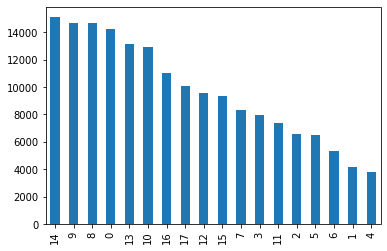

In [80]:
print('class 결측값 : ',all_df['class'].isnull().sum())
print(all_df['class'].value_counts())
all_df['class'].value_counts().plot(kind='bar')

In [85]:
all_df.to_csv("all_df_pText.csv")

In [90]:
all_df = pd.read_csv('all_df_pText.csv',index_col='Unnamed: 0')

In [92]:
all_df[all_df['class'] == 1].iloc[[0,1,2]]
# df[df['class'] == y].iloc[top_n_sim]

,class,text,title,keyword,likes,share,comment,publish_date,url,ori_class
14207,1,사는데 정통만 있는 게 아니고 짝퉁도 많다 구찌 명품백을 따라 하는 구짜 백과 남의...,야매 몬테크리스토 샌드위치,"['샌드위치', '짝퉁', '레시피']",NaN,NaN,6.0,2020-05-14,https://brunch.co.kr/@mkj711/163,요리_레시피
14208,1,달콤하고 촉촉한 카스테라 국물과 면발이 끝내주는 짬뽕 테마파크 하우스텐보스 다들 어...,File3 나가사키현 - 와카란요리,"['나가사키', '요리', '카스테라']",NaN,NaN,NaN,2020-05-14,https://brunch.co.kr/@jwkimpd/23,요리_레시피
14209,1,아이와 함께 먹을 수 있는 요리를 하려다 보니 내가 먹고 싶음 음식들과는 멀어진다 ...,매운 해물 토마토 스파게티,"['요리', '마흔', '에세이']",NaN,NaN,NaN,2020-05-14,https://brunch.co.kr/@yoondori1981/21,요리_레시피
